In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import re
import locale
locale.setlocale(locale.LC_ALL, '')
import sys
import subprocess
from scipy.optimize import minimize

In [2]:
comps = pd.read_excel('tabulated_data.xlsm', sheet_name='Compositions')
compNames = list(comps)[1:]
comps

Name McLeod-Mix1                   McLeod-Mix2  \
0           Group      McLeod                        McLeod   
1          Sample        Mix1                          Mix2   
2              SG    0.705971                      0.652476   
3   Inert Free SG    0.560051                      0.558915   
4             CO2       0.005                         0.003   
5             H2S       0.226                        0.1438   
6              N2      0.0046                        0.0046   
7             Gas      0.7644                        0.8486   
8          PMC Tc  329.077791                    328.718682   
9          PMC Pc  684.491836                    684.709735   
10    Tc w/Inerts  395.011617                    370.587434   
11    Pc w/inerts    776.7336                    743.770239   
12         Sut Tc  341.727328                    341.424212   
13         Sut Pc  682.304087                    682.457555   
14        Tc_Mult     1.01879                       1.00718   
15        Pc_Mult    0.981998                      0.973568   
16         Tc_Fit  348.148384                    343.875638   
17         Pc_Fit  670.021249                    664.418836   
18            NaN         NaN                           NaN   
19            NaN         Max                          Case   
20            CO2      0.5446         Robinson&Jacoby-Mix10   
21            H2S      0.7385  Dataset6-PantherRiver5-23#12   
22             N2      0.2515                 API 37-Mix735   
23            NaN         NaN                           NaN   
24            NaN         NaN                           NaN   
25            NaN         NaN                           NaN   
26            NaN         NaN                           NaN   
27            NaN         NaN                           NaN   
28            NaN         NaN                           NaN   
29            NaN         NaN                           NaN   
30            NaN         NaN                           NaN   
31            NaN         NaN                           NaN   
32            NaN         NaN                           NaN   
33            NaN         NaN                           NaN   
34            NaN         NaN                           NaN   
35            NaN         NaN                           NaN   
36            NaN         NaN                           NaN   
37            NaN         NaN                           NaN   
38            NaN         NaN                          mult   
39            NaN          tc                       1.05272   
40            NaN          pc                      0.607851   
41            NaN         NaN                        Sut Tc   
42            NaN         0.5                        325.45   
43            NaN         0.6                        352.26   
44            NaN         0.7                        377.59   
45            NaN         0.8                        401.44   
46            NaN         0.9                        423.81   
47            NaN         1.0                         444.7   
48            NaN         1.1                        464.11   
49            NaN         1.2                        482.04   
50            NaN         1.3                        498.49   
51            NaN         1.4                        513.46   
52            NaN         1.5                        526.95   

                     McLeod-Mix3 McLeod-Mix22 McLeod-Mix24 McLeod-Mix25  \
0                         McLeod       McLeod       McLeod       McLeod   
1                           Mix3        Mix22        Mix24        Mix25   
2                       0.609878     0.698439     0.741612      0.59657   
3                       0.560063     0.681036     0.736766     0.592865   
4                         0.0131        0.018       0.0061        0.004   
5                          0.057            0            0            0   
6                         0.0052       0.0081            0            0   
7         

In [3]:
def make_valid_filename(input_string):
    valid_filename = re.sub(r'[^\w.-]', '_', input_string)
    valid_filename = valid_filename.strip()
    valid_filename = re.sub(r'[-_.]{2,}', '_', valid_filename)
    valid_filename = valid_filename.replace('@', '_').replace('#', '_')
    return valid_filename

In [4]:
R, mwAir, degF2R = 10.731577089016, 28.97, 459.67
class mix:
    def __init__(self, name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc):
        self.comps = [co2, h2s, n2, gas]
        self.compnames = ['CO2', 'H2S', 'N2', 'Gas']
        self.name = make_valid_filename(name)
        self.group = group
        self.sample = sample
        self.sg = sg
        mws = np.array([44.01, 34.082, 28.014, 0])
        self.sg_hc = (sg - (co2 * mws[0] + h2s * mws[1] + n2 * mws[2]) / mwAir) / (1 - co2 - h2s - n2)
        mw_gas = self.sg_hc * mwAir
        self.pc = coefic_pc[0] * mw_gas ** 2 + coefic_pc[1] * mw_gas + coefic_pc[2]
        self.tc = coefic_tc[0] * mw_gas ** 2 + coefic_tc[1] * mw_gas + coefic_tc[2]          
        self.expmt = pd.read_excel('tabulated_data.xlsm', sheet_name=name)
        
    def write_include(self, base_chr): # Write include files for 4 component model
        out_str = 'CHARACTERIZATION "CHR_'+self.name+'" BASE "'+base_chr+'"\n'
        header = ['COMPONENT', 'MW', 'TC,R', 'PC,PSIA', 'AF', 'VTRAN', 'A', 'B', 'AMOD', 'BMOD']
        rows = []
        for c in range(len(self.compnames)):
            rows.append([self.compnames[c], '', '', '', '', '', '', '', '', ''])
        rows[-1][1] = round(self.sg_hc * 28.97, 2)
        rows[-1][2] = round(self.tc,2)
        rows[-1][3] = round(self.pc,2)

        out_str += tabulate(rows, header)
        out_str += '\nEND\n\n'
        
        out_str += 'MIX '+self.name+'\n'
        rows = []
        for c in range(len(self.compnames)):
            rows.append([self.compnames[c], self.comps[c]])
        out_str += tabulate(rows)
        out_str += '\nEND\n\n'

        out_str += 'QIX FEED 1 MOLE '+self.name+'\n'
        out_str += 'CCE ID "'+self.name+'"\n'

        exp_df = pd.DataFrame()
        exp_df['TEMP (F)']= self.expmt['degf']
        exp_df['PRES (psia)']= self.expmt['psia']
        exp_df['GZ']= self.expmt['Z']

        out_str += tabulate(exp_df, headers='keys', showindex='never', numalign='left')
        out_str += '\nEND\n\n'

        return out_str


In [5]:
phz_template = 'Inerts_PR_Match_VSHIFT_Only_AB_CO2_BigLoop.phz' # The .Phz file to use as the base
Phz_loc = "C:\\Temp\\PhazeComp\\phazecomp.exe"         # The location of the PhazeComp executable on your system

def create_phz(phz_template):
    rms=float("nan")
    try:
        proc = subprocess.run([Phz_loc, phz_template,'NUL',">"], capture_output=True)
    except:
        print("Either phazecomp.exe couldnt be found (is it in "+Phz_loc+" ?), or "+phz_template+" couldn't be found - Exiting..")
        sys.exit()
    
    found_rms = False
    for i in range(len(proc.stderr.splitlines())-1,0,-1):
        line = proc.stderr.splitlines()[i].decode("utf-8")
        if "% RMS average weighted" in line:
            rms = float(line.split()[2])
            found_rms = True
            break
    if not found_rms:
        print("Error: No RMS for ",phz_template)
    return rms

In [6]:

def fn(x):
    coefic_pc = x[:3]
    coefic_tc = x[3:]
    comp_dic = {}
    for c in range(len(compNames)):
        name = compNames[c]
        group = comps.iloc[0, c+1]
        sample = comps.iloc[1, c+1]
        sg = comps.iloc[2, c+1]
        co2 = comps.iloc[4, c+1]
        h2s = comps.iloc[5, c+1]
        n2 = comps.iloc[6, c+1]
        gas = comps.iloc[7, c+1]
        comp_dic[name] = mix(name, group, sample, sg, co2, h2s, n2, gas, coefic_pc, coefic_tc)
    
    # 4 component include files
    for c in range(len(compNames)):
        file_path = make_valid_filename(compNames[c])
        string = comp_dic[compNames[c]].write_include('RealGas')
        with open('.\\BigLoop_CO2AB\\'+file_path+'.inc', 'w') as file:
            file.write(string)
    
    rms = create_phz(phz_template)
    print(x, rms)
    return rms

In [8]:
x0 = [-4.01841583e-03, -2.75078362e+00, 7.07644217e+02, -8.86950457e-02, 1.29170902e+01, 1.57873612e+02]

bounds = [(-10, 2), (-10, 2), (3, 1000), (-10, 2), (-2, 50), (50, 500)]
sol = minimize(fn, x0, method='Nelder-Mead', bounds=bounds)

[-4.01841583e-03 -2.75078362e+00  7.07644217e+02 -8.86950457e-02
  1.29170902e+01  1.57873612e+02] 1.302
[-4.21933662e-03 -2.75078362e+00  7.07644217e+02 -8.86950457e-02
  1.29170902e+01  1.57873612e+02] 1.302
[-4.01841583e-03 -2.88832280e+00  7.07644217e+02 -8.86950457e-02
  1.29170902e+01  1.57873612e+02] 1.306
[-4.01841583e-03 -2.75078362e+00  7.43026428e+02 -8.86950457e-02
  1.29170902e+01  1.57873612e+02] 1.675
[-4.01841583e-03 -2.75078362e+00  7.07644217e+02 -9.31297980e-02
  1.29170902e+01  1.57873612e+02] 1.304
[-4.01841583e-03 -2.75078362e+00  7.07644217e+02 -8.86950457e-02
  1.35629447e+01  1.57873612e+02] 1.593
[-4.01841583e-03 -2.75078362e+00  7.07644217e+02 -8.86950457e-02
  1.29170902e+01  1.65767293e+02] 1.438
[-4.08538943e-03 -2.79663001e+00  6.72262006e+02 -9.01732965e-02
  1.31323750e+01  1.60504839e+02] 1.993
[-4.03515923e-03 -2.76224522e+00  7.25335322e+02 -8.90646084e-02
  1.29709114e+01  1.58531419e+02] 1.397
[-4.09097056e-03 -2.80045055e+00  7.13541252e+02 -9.029

In [9]:
# Run once at the end to ensure the directory of experiments reflects the solution case
fn(sol.x)

[-4.01841583e-03 -2.75078362e+00  7.07644217e+02 -8.86950457e-02
  1.29170902e+01  1.57873612e+02] 1.302


1.302

## Contrast custom critical properties with Sutton properties

In [10]:
def sutton(sg_hc):
    ppc_hc = 756.8 - 131.0 * sg_hc - 3.6 * sg_hc ** 2  # Eq 3.47b
    tpc_hc = 169.2 + 349.5 * sg_hc - 74.0 * sg_hc ** 2  # Eq 3.47a
    return (tpc_hc, ppc_hc)

# Modified Sutton Tc and Pc
def tc_pc(sg_hc):
    coefic_pc = sol.x[:3]
    coefic_tc = sol.x[3:]
    mw_gas = mwAir * sg_hc
    ppc_hc = coefic_pc[0] * mw_gas ** 2 + coefic_pc[1] * mw_gas + coefic_pc[2]
    tpc_hc = coefic_tc[0] * mw_gas ** 2 + coefic_tc[1] * mw_gas + coefic_tc[2] 
    return (tpc_hc, ppc_hc)
    

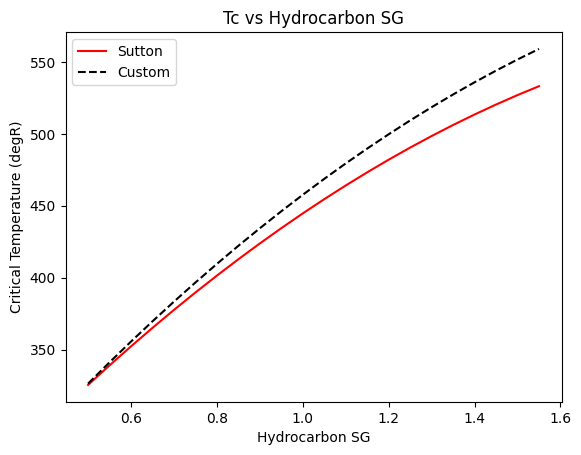

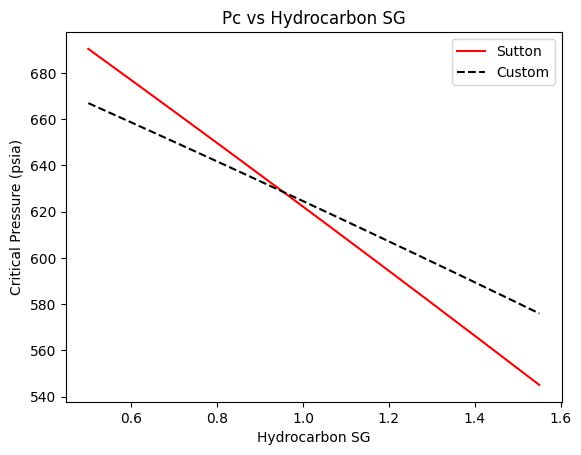

In [11]:
tc, pc = [[], []], [[], []]

sgs = np.arange(0.5, 1.6, 0.05)
for sg in sgs:
    sut_tc, sut_pc = sutton(sg)
    cust_tc, cust_pc = tc_pc(sg)
    tc[0].append(sut_tc)
    tc[1].append(cust_tc)
    pc[0].append(sut_pc)
    pc[1].append(cust_pc)

plt.plot(sgs, tc[0], '-', c='r', label='Sutton')
plt.plot(sgs, tc[1], '--', c='k', label='Custom')
plt.title('Tc vs Hydrocarbon SG')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Temperature (degR)')
plt.legend()
plt.show()

plt.plot(sgs, pc[0], '-', c='r', label='Sutton')
plt.plot(sgs, pc[1], '--', c='k', label='Custom')
plt.xlabel('Hydrocarbon SG')
plt.ylabel('Critical Pressure (psia)')
plt.title('Pc vs Hydrocarbon SG')
plt.legend()
plt.show()